# Google Drive mounting

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/coin-wear-estimator/')
!pip3 install -r requirements.txt --quiet
os.chdir('./notebook')

Mounted at /content/drive
     |████████████████████████████████| 911kB 32.5MB/s 
     |████████████████████████████████| 346.3MB 44kB/s 
     |████████████████████████████████| 13.1MB 17.1MB/s 
     |████████████████████████████████| 50.4MB 103kB/s 
     |████████████████████████████████| 56.4MB 76kB/s 
     |████████████████████████████████| 296kB 53.4MB/s 
     |████████████████████████████████| 3.4MB 36.1MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 8.3MB 24.3MB/s 
     |████████████████████████████████| 880kB 52.5MB/s 
     |████████████████████████████████| 317kB 52.3MB/s 
     |████████████████████████████████| 59.9MB 73kB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: h2o4gpu 0.4.1 has requirement scikit-learn==0.21.2, but you'll have scikit-learn 0.22.2.post1 which is incompatible.


# Imports and constants

In [4]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
  sys.path.append("..")

import itertools
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from src.detector import crop_coin
import pandas as pd
from src.utils import *
from src.detector import crop_coin, create_circular_mask
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
# from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

[autoreload of psutil failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'AccessDenied' from 'psutil._common' (/usr/local/lib/python3.7/dist-packages/psutil/_common.py)
]
[autoreload of psutil._pslinux failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'psutil_posix' has no attribute 'getpagesize'
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploration

In [ ]:
def calculate_sizes(root, csv_path):
    names = [name for name in os.listdir(root) if name.split(".")[-1] == "jpg"]
    df = pd.DataFrame({"name": names, "size": None})

    pbar = tqdm(total=len(df))
    for i, row in df.iterrows():
        row["size"] = Image.open(root + "/" + row["name"]).size[0]
        pbar.update(1)
    df.to_csv(csv_path, index=None)
    pbar.close()

calculate_sizes(aligned_coins_path(NIEMCZYK_DATASET_PATH), size_aligned_path(NIEMCZYK_DATASET_PATH))
calculate_sizes(aligned_coins_path(MARCINIAK_DATASET_PATH), size_aligned_path(MARCINIAK_DATASET_PATH))

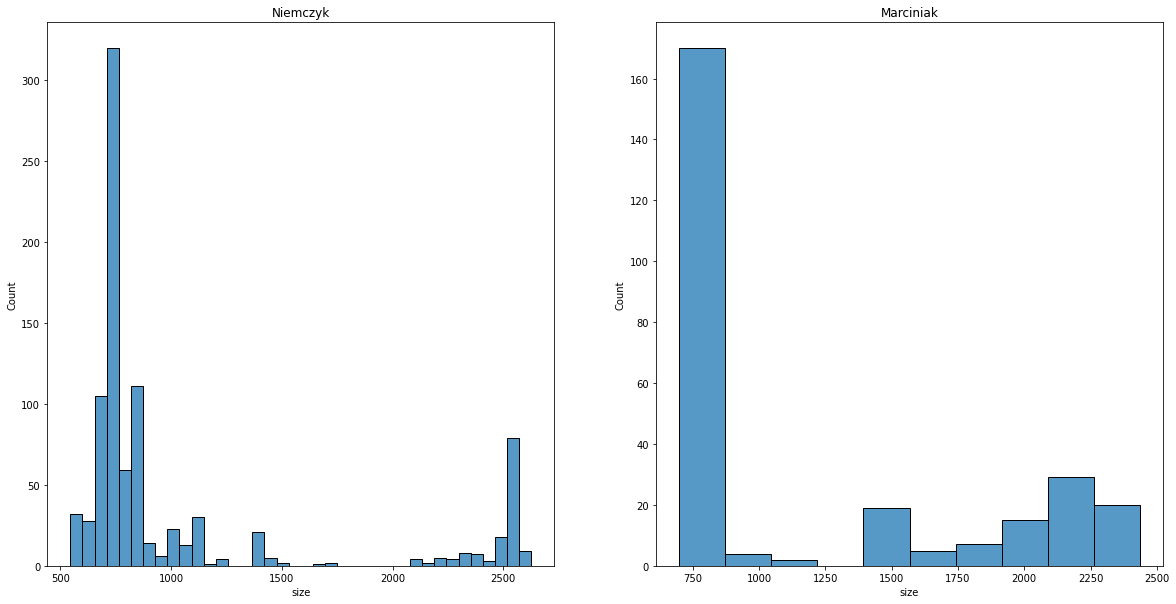

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, ds_path in enumerate([NIEMCZYK_DATASET_PATH, MARCINIAK_DATASET_PATH]):
  df = pd.read_csv(size_aligned_path(ds_path))
  sns.histplot(df["size"], ax=ax[i])

ax[0].set_title("Niemczyk")
ax[1].set_title("Marciniak")
plt.show()


# Master coin

In [6]:
def get_design_mask(master_coin):
    mask = master_coin.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.Canny(mask, 0.1*255, 0.2*255)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    mask = cv2.dilate(mask, kernel ,iterations = 1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mas

## General master coin

In [7]:
def generate_general_master_coin(label):
  array_df_size = []
  array_df_side = []
  for ds_path in [MARCINIAK_DATASET_PATH, NIEMCZYK_DATASET_PATH]: 
    df = pd.read_csv(size_aligned_path(ds_path))
    df["name"] = df["name"].apply(lambda x: aligned_coins_path(ds_path) + "/" + x)
    array_df_size.append(df)

    df =  pd.read_csv(side_path(ds_path))
    df["name"] = df["name"].apply(lambda x: aligned_coins_path(ds_path) + "/" + x)
    array_df_side.append(df)

  df_size = pd.concat(array_df_size)
  df_side = pd.concat(array_df_side)

  df = df_size.merge(df_side, how='inner', on='name')
  df = df.sort_values(by=['size'], ascending=False)
  df = df[df["label"] == label]
  names = df["name"]
  stack = np.stack([cv2.resize(cv2.imread(name), (700,700)) for name in names])
  master_coin = np.uint8(np.mean(stack, axis=0))

  return master_coin

# mc_1 = generate_general_master_coin(1)
# mc_2 = generate_general_master_coin(2)
mc_1 = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_general.jpg")
mc_2 = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_general.jpg")

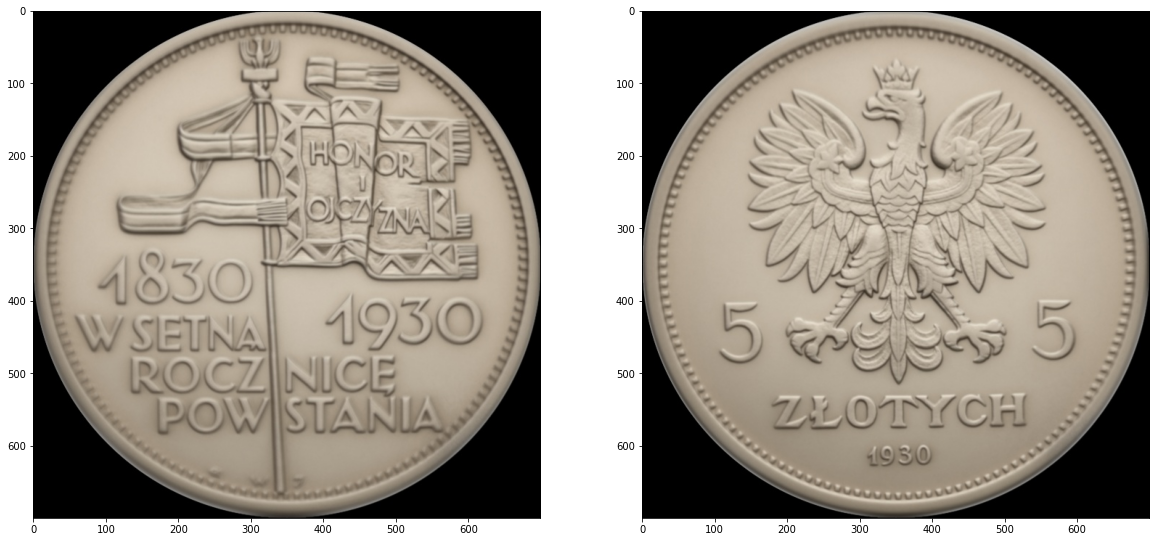

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(cv2.cvtColor(mc_1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(mc_2, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_general.jpg", mc_1)
# cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_general.jpg", mc_2)

True

In [141]:
def remove_illumination(im, kernel_size, sigma):
    back = cv2.GaussianBlur(im, (61,61), 0)
    im = im.astype("float")
    im = np.subtract(im, back)
    im = im + np.mean(back)
    mask = create_circular_mask(im.shape[0], im.shape[1])
    im[~mask] = 0
    im[im < 0] = 0
    im[im > 255] = 255
    im = np.uint8(im)
    return im

def get_design_mask(master_coin, canny_l=14, cann_u=30):
    mask = master_coin.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    mask = cv2.medianBlur(mask, 3)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    mask = cv2.dilate(mask, kernel ,iterations = 1)

    mask = remove_illumination(mask, (61,61), 0)

    mask = cv2.Canny(mask, canny_l, cann_u)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.dilate(mask, kernel ,iterations = 3)

    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

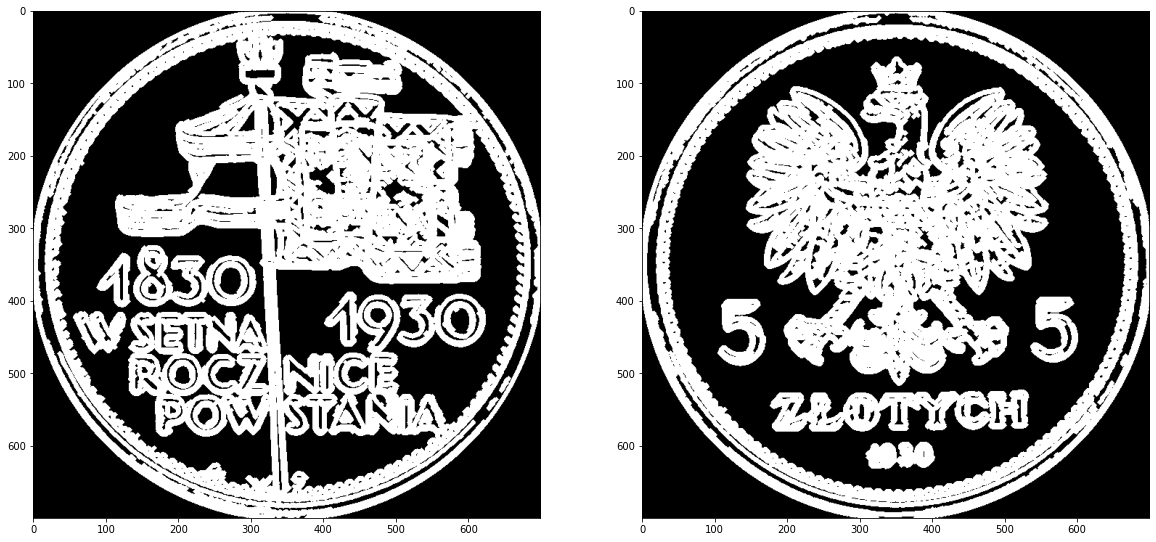

In [142]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

for i, mc in enumerate([mc_1, mc_2]):
    im = get_design_mask(mc)
    ax[i].imshow(im, cmap='gray')
  
plt.show()

## Specific master coin

In [ ]:
def generate_master_coin(root, label):
  df1 = pd.read_csv(size_aligned_path(root))
  df2 = pd.read_csv(side_path(root))
  df = df1.merge(df2, how='inner', on='name')
  df = df.sort_values(by=['size'], ascending=False)
  df = df[df["label"] == label]
  names = df["name"]
  stack = np.stack([cv2.resize(cv2.imread(aligned_coins_path(root) + "/" + name), (700,700)) for name in names[:100]])
  master_coin = np.uint8(np.mean(stack, axis=0))

  return master_coin

master_coin_1_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/1.jpg", master_coin_1_n)
master_coin_2_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/2.jpg", master_coin_2_n)
master_coin_1_m = generate_master_coin(MARCINIAK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg", master_coin_1_m)
master_coin_2_m = generate_master_coin(MARCINIAK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg", master_coin_2_m)

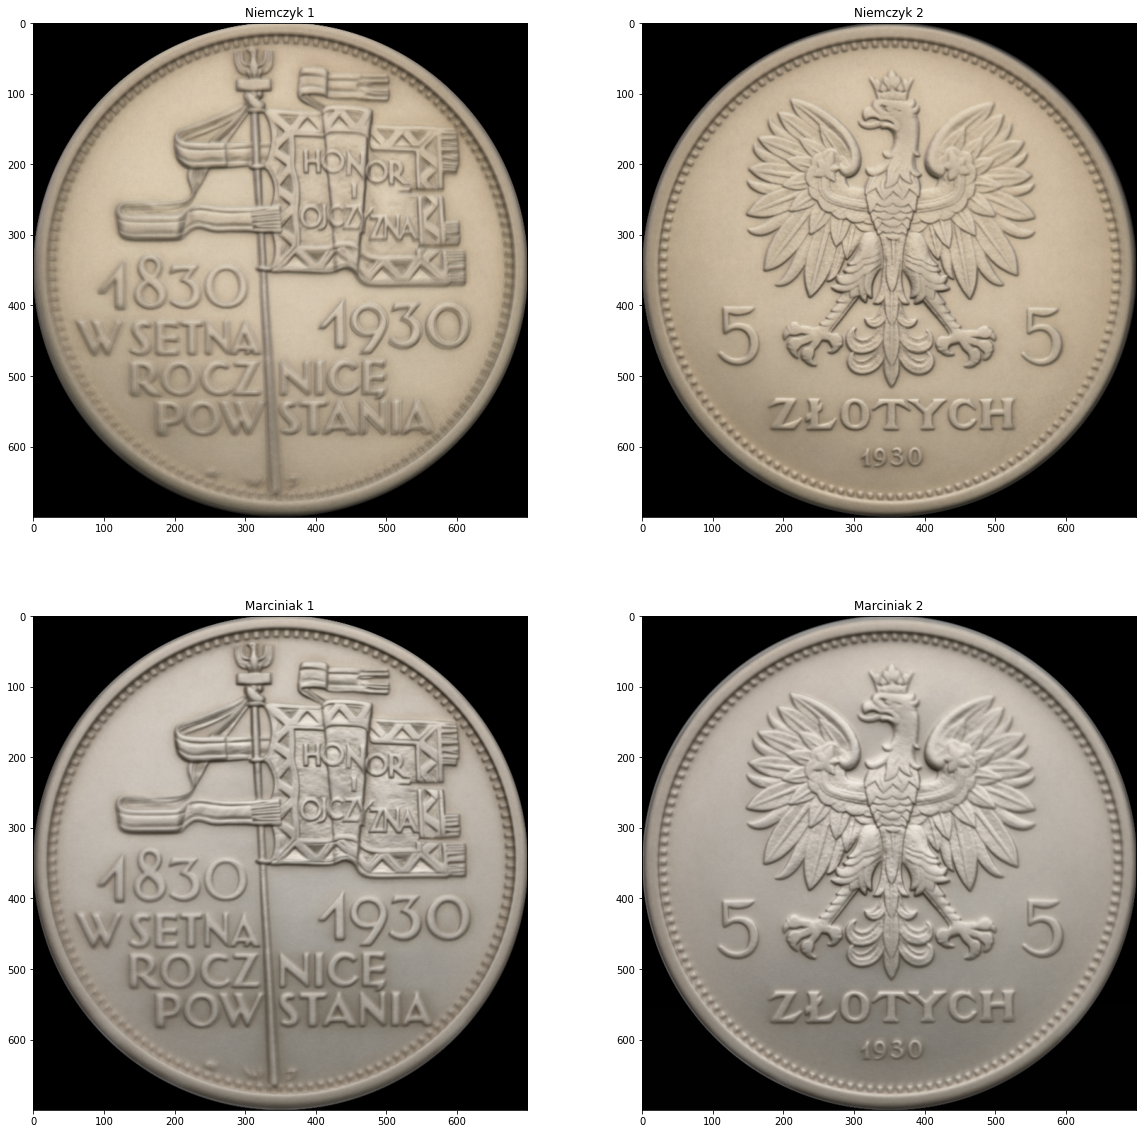

In [ ]:
master_coin_1_n = cv2.imread(master_coins_path(NIEMCZYK_DATASET_PATH) + "/1.jpg")
master_coin_2_n = cv2.imread(master_coins_path(NIEMCZYK_DATASET_PATH) + "/2.jpg")
master_coin_1_m = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg")
master_coin_2_m = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg")

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
ax1.imshow(cv2.cvtColor(master_coin_1_n, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(master_coin_2_n, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(master_coin_2_m, cv2.COLOR_BGR2RGB))

ax1.set_title("Niemczyk 1")
ax2.set_title("Niemczyk 2")
ax3.set_title("Marciniak 1")
ax4.set_title("Marciniak 2")

plt.show()

# Wear marks

In [121]:
def get_wear_marks(coin, design_mask):
    coin = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    coin = cv2.resize(coin, (700,700))
    # coin = cv2.GaussianBlur(coin, (3,3), 0.5)
    coin = cv2.medianBlur(coin, 3)
    coin = cv2.Canny(coin, 0.6*255, 0.8*255)
    coin = np.multiply(~design_mask.astype(bool), coin)
    # coin = np.repeat(coin[:, :, np.newaxis], 3, axis=2)
    # coin[design_mask.astype(bool), 0] = 255
    return coin

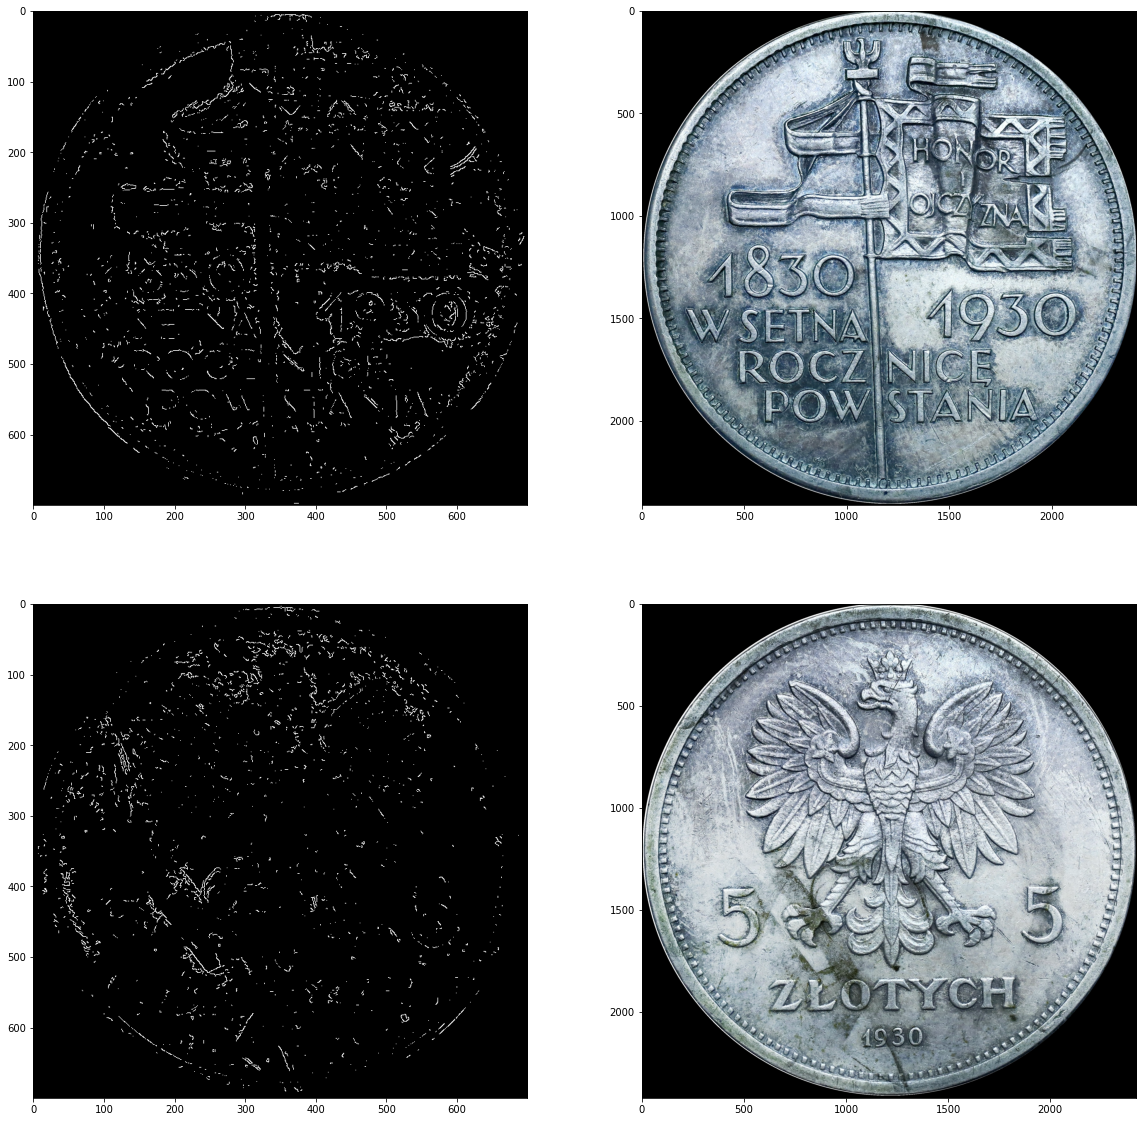

In [144]:
design_mask_1 = get_design_mask(mc_1)
design_mask_2 = get_design_mask(mc_2)

test_coin_1 = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/2_3.jpg')
wear_marks_1 = get_wear_marks(test_coin_1, design_mask_1)

test_coin_2 = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/2_2.jpg')
wear_marks_2 = get_wear_marks(test_coin_2, design_mask_2)


fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(wear_marks_1, cmap='gray')
ax[0,1].imshow(test_coin_1, cmap='gray')
ax[1,0].imshow(wear_marks_2, cmap='gray')
ax[1,1].imshow(test_coin_2, cmap='gray')
plt.show()

# Illumination removing

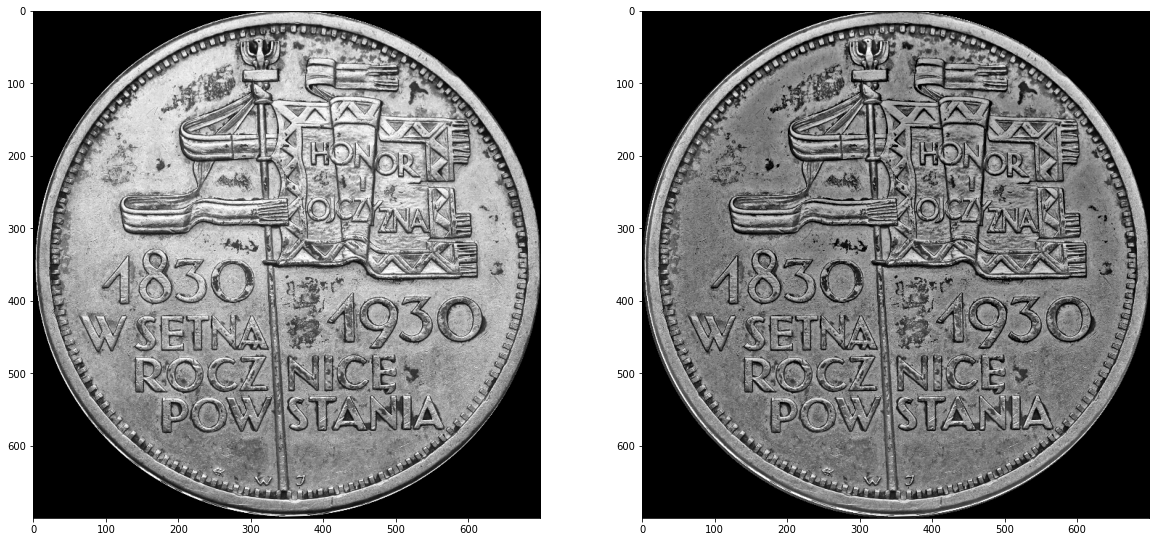

In [147]:
test_im = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_1.jpg')
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
test_im = cv2.resize(test_im, (700,700))
no_illum_im = remove_illumination(test_im, (61, 61), 0)

fig, ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(test_im, cmap='gray')
ax[1].imshow(no_illum_im, cmap='gray')

plt.show()